In [1]:
!pip3 install ffmpeg-python

In [2]:
!pip3 install pydub

In [3]:
import numpy
import pandas as pd
import numpy as np
import pandas as pd
import librosa.display
import scipy.io.wavfile
from scipy.fftpack import dct
import IPython.display as ipd
import matplotlib.pyplot as plt
from pydub import AudioSegment
from keras import optimizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from tensorflow.keras.layers import Dense, LSTM, Dropout
import os, shutil, ffmpeg, audioread, tqdm, librosa, random
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

# Data Preprocessing

In this project I use the mizilla dataset. It is 2GB of MP3 recordings of French voices. 72% Male, 7% Female. I imported the data on my drive and share the link with you.

In [4]:
# This is the dataset of characteristics of all the recordings that I downloaded. 
df = pd.read_csv("/content/drive/My Drive/balanced.csv")

In [5]:
df.head()

,Unnamed: 0,client_id,path,sentence,up_votes,down_votes,age,gender,accent
0,61506,5796619efc6fd2fb8e28212f444fea1970228fdfb127e3...,83c028a752aa18b1c5c35cedd14d2d60758bc2f47e1b6a...,"Quant au père Chose, je l'entrevois.",2,0,twenties,male,france
1,15592,3c2e743e18010a5e520d271a280813b477c2b02541b945...,4cc1ca2a677b79d81207fa770aff776f64a775c18429aa...,Nous vivons au Wisconsin.,2,0,twenties,male,belgium
2,5301,87a669e1d87b7d8767a103b0bdb5b9b236da774b00708f...,7029dd776c0c0cc1f8b61b773dfbb23844fcd9fbd3003b...,Quand on a froid on attrape la crève.,2,0,twenties,male,france
3,68199,c855e9ec9c252347589bda2eb0859d133cb2a11016ea61...,ad191ca39c3b200a8640093c001897d2a76c8d9392b779...,"cent quatre-vingt-quinze allée du Barbaroux, q...",2,1,twenties,male,france
4,30294,87b7d5d0cf3cfe2d40ddcf5075c94fe183582a305f6711...,6236601b598d071dee0cec5ba48e9fbe3bfbff6528fb92...,"Encore un décret, deux décrets, quatre décrets...",2,0,teens,male,france


Here I convert the mp3 recording to WAV format for processing convenience.

In [6]:
#Convert all audio from mp3 to .wav
name_dict = {}

for ind, name in enumerate(((df['path']))):

  #get old filename
  old_filename = ''.join(('/content/drive/My Drive/balanced_mp3_1/balanced_mp3/', name))

  #Create new filename
  new_filename = ''.join(('rec_', str(ind), '.wav'))

  # Uncomment the following lines to save the new audio files
  # song = AudioSegment.from_mp3(old_filename)
  # song.export(''.join(('/content/drive/My Drive/wav_rec/', new_filename)), format="wav")

  name_dict[name] = new_filename

  # print(new_filename)

In [7]:
# Remove bad recordings
df = df[df['down_votes']==0]

In [8]:
df.shape

(8707, 9)

# Audio analysis

In [9]:
# Listen to audio example
audio_path = '/content/drive/My Drive/wav_rec/rec_7.wav'
x , sr = librosa.load(audio_path)
print(type(x), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [261]:
ipd.Audio(audio_path)

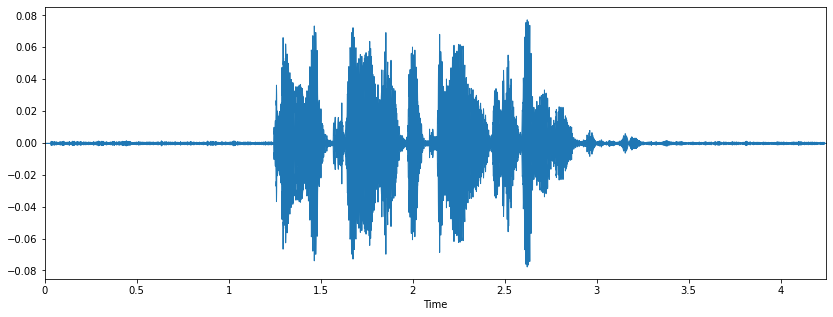

In [262]:
# Display waveform
%matplotlib inline
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

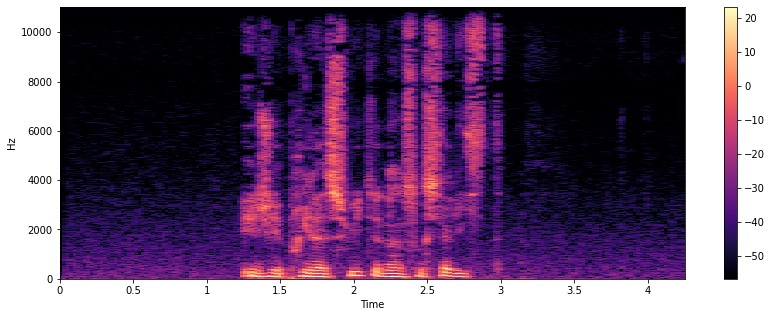

In [263]:
# Display Spectrogram
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
#If to pring log of frequencies  
#librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

I noted that not all the recordings have the same time frame.

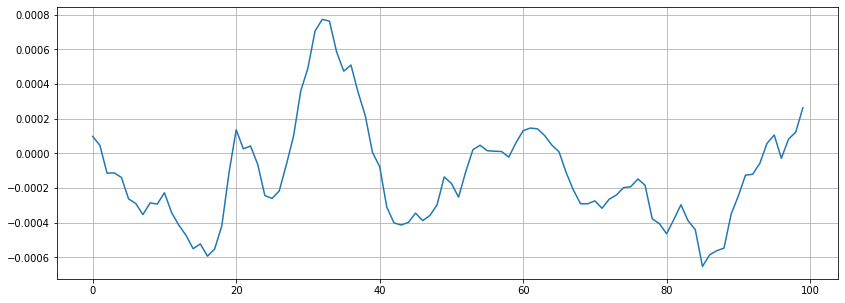

In [265]:
# Zooming in
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

(20, 183)


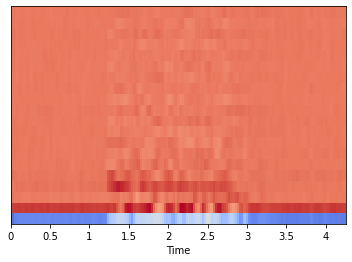

In [266]:
# Displaying  the MFCCs
mfccs = librosa.feature.mfcc(x, sr=sr)
print(mfccs.shape)
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

In [267]:
mfccs

array([[-7.45496826e+02, -6.64341980e+02, -6.27674927e+02, ...,
        -6.37329956e+02, -6.41731018e+02, -6.42749207e+02],
       [ 4.36444092e+01,  9.83710785e+01,  1.07636414e+02, ...,
         1.06301338e+02,  1.03035645e+02,  9.89336395e+01],
       [ 2.64882431e+01,  1.06299152e+01, -7.62388349e-01, ...,
        -2.70011759e+00,  3.72654378e-01, -5.20716846e-01],
       ...,
       [ 8.90844345e+00,  1.21236248e+01,  5.74000549e+00, ...,
        -9.62538242e-01,  2.44919062e+00,  7.98407745e+00],
       [ 3.52047062e+00,  3.77933073e+00,  1.02356315e+00, ...,
        -2.10233545e+00, -7.09543991e+00, -6.61681652e+00],
       [-3.11575079e+00,  2.05336237e+00,  2.58866692e+00, ...,
         5.42449951e-01,  4.17535484e-01, -3.31734240e-01]], dtype=float32)

In [268]:
len(mfccs)

20

# Data preparation

## Function to process the audio recording

In [270]:
# Function to process the audio recordings

def mp3_processing (file_path) :
  
  x, sr = librosa.load(file_path, duration=3, sr=48000)

  ### Step 1 : pre-emphasis ###
  pre_emp = 0.97
  emp_signal = np.append(x[0], x[1:] - pre_emp * x[:-1])

  ### Step 2 : Framing ###
  size = 0.025
  stride = 0.01
  # Convert from seconds to samples
  frame_length, frame_step = size * sr, stride * sr
  signal_length = len(emp_signal)
  frame_length = int(round(frame_length))
  frame_step = int(round(frame_step))
  # Make sure that we have at least 1 frame
  num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))
  pad_signal_length = num_frames * frame_step + frame_length
  zer = np.zeros((pad_signal_length - signal_length))
  # Pad Signal to make sure that all frames have equal number of samples
  pad_signal = np.append(emp_signal, zer) 
  indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
  frames = pad_signal[indices.astype(np.int32, copy=False)]

  ### Step 3 : Windowing ###
  frames *= np.hamming(frame_length)

  ### Step 4 :  Fourier transform and power spectrum ###
  NFFT = 512
  # Magnitude of the FFT
  mag = np.absolute(np.fft.rfft(frames, NFFT))
  pow = ((1.0 / NFFT) * ((mag) ** 2))  # Power Spectrum

  ### Step 5 : Filter banks ###
  nfilt = 40 
  low_freq_mel = 0
  # Convert Hz to Mel
  high_freq_mel = (2595 * np.log10(1 + (sr / 2) / 700))
  # Equally spaced in Mel scale
  mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)
  # Convert Mel to Hz  
  hz_points = (700 * (10**(mel_points / 2595) - 1))
  bin = np.floor((NFFT + 1) * hz_points / sr)
  fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
  for m in range(1, nfilt + 1):
      f_m_minus = int(bin[m - 1])   # left
      f_m = int(bin[m])             # center
      f_m_plus = int(bin[m + 1])    # right

      for k in range(f_m_minus, f_m):
          fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
      for k in range(f_m, f_m_plus):
          fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
  filt_banks = np.dot(pow, fbank.T)
  filt_banks = np.where(filt_banks == 0, np.finfo(float).eps, filt_banks)  # Numerical Stability
  filt_banks = 20 * np.log10(filt_banks)  # dB
  
  ### Step 6 : Mel-Frequency Cepstral coefficients MFCCS output ###
  num_ceps = 12
  cep_lifter = 22
  mfcc = dct(filt_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
  (nframes, ncoeff) = mfcc.shape

  # Apply sinusoidal filtering
  n = np.arange(ncoeff)
  lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
  mfcc *= lift

  # Mean normalization
  mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
  
  # Give the appropriate size
  z = np.zeros(((298 - mfcc.shape[0]), 12))
  mfcc = np.concatenate( (mfcc, z), axis=0)
  result = np.reshape(mfcc, (3576,))

  # Give the same size
  return result
  

In [271]:
mp3_processing(audio_path).shape

(3576,)

## Get a balanced dataset

Since we have more male recording than female recordings, I balance the dataset by selecting 1000 male samples and 1000 female samples.

In [272]:
random.seed(42)
list_ind = df[df['gender']=='male'].index.tolist()
male_sample_nb= random.sample(list_ind, 2000)

In [273]:
random.seed(42)
list_ind = df[df['gender']=='female'].index.tolist()
female_sample_nb= random.sample(list_ind, 2000)

In [274]:
tot = []
t = [tot.append(ind) for ind in male_sample_nb]
t = [tot.append(ind) for ind in female_sample_nb]
len(tot)

4000

In [275]:
data = df.loc[tot].copy()

In [276]:
# Get all wav audio file names
names = []
names = [name.split('.')[0] for name in os.listdir('/content/drive/My Drive/wav_rec/')]

In [277]:
# Select the 2000 recordings for training
names = [val for keys, val in name_dict.items() if keys in data['path'].tolist()] 

In [278]:
len(names)

4000

## Process the audio recordings

In [279]:
# Process the 2000 recordings and place them in a new directory for convenience
#os.mkdir("/content/drive/My Drive/processed_wav/")
for name in names :
  path = ''.join(('/content/drive/My Drive/wav_rec/',name))
  new_path = ''.join(('/content/drive/My Drive/processed_wav/', name.split('.')[0]))
  
  # Uncomment the next line to create the processed directory made of the 2000 recordings
  # np.save(new_path, mp3_processing(path))
  # print(mp3_processing(path).shape)

In [280]:
[name.split('.')[0] for name in os.listdir('/content/drive/My Drive/processed_wav/')][:5]

['rec_1', 'rec_5', 'rec_8', 'rec_12', 'rec_13']

In [281]:
# Create a dataframe with the correspondance old path - new name
dt = pd.DataFrame(data={'path':name_dict.keys(), 'filename':name_dict.values()})
d = [data, dt]
dat = pd.concat(d, join="inner", axis=1)

In [282]:
dt.iloc[0]

path        83c028a752aa18b1c5c35cedd14d2d60758bc2f47e1b6a...
filename                                            rec_0.wav
Name: 0, dtype: object

In [283]:
# Export our CSV
dat.to_csv('data.csv')

In [284]:
dat[:5]

,Unnamed: 0,client_id,path,sentence,up_votes,down_votes,age,gender,accent,path,filename
1000,48002,6cfbb8894fc5df8138bd0ed202d0bda3527e69d36b7a1a...,94950bec6d0190c0af403019fc5a134234f08c802d24e9...,"La parole est à Madame Geneviève Gaillard, pou...",2,0,thirties,male,france,94950bec6d0190c0af403019fc5a134234f08c802d24e9...,rec_1000.wav
218,17313,6b88a83efe93bce1533466f135feda38ca64200d2be712...,71483812d08a2bc00fd20cec3fdfc4fa785f199ed570fd...,Plusieurs orateurs sont inscrits à cet article.,2,0,fourties,male,france,71483812d08a2bc00fd20cec3fdfc4fa785f199ed570fd...,rec_218.wav
2476,48975,1653ff7efc02d8f0e0d8be05adb19e1bfca543cee27730...,f184fa5ec956e796672343131b961b05206d648016ce10...,cinq impasse de Tordes,2,0,fourties,male,france,f184fa5ec956e796672343131b961b05206d648016ce10...,rec_2476.wav
2207,10637,faa07254360943d7860a953a704a9ee994ba421da76d31...,c3ca9ac90d7ba3ade929d12721b3be33e199ad3facfd29...,il est épouvantable d'entendre de telles choses.,2,0,thirties,male,france,c3ca9ac90d7ba3ade929d12721b3be33e199ad3facfd29...,rec_2207.wav
2005,38242,3622394ea040ebe62e3efff6691a282617c69c5140d9df...,2f4e1312a6b9f47e23e3ff3709d71f093abd3998e99098...,Vos pantalons me deviennent deux fois trop lar...,2,0,twenties,male,france,2f4e1312a6b9f47e23e3ff3709d71f093abd3998e99098...,rec_2005.wav


## Useful functions

Now that I have a clean dataset to work with, lets create some useful functions.

In [285]:
# Labels
label2int = {
    "male": 1,
    "female": 0
}

In [286]:
def load_data(vector_length=3576, path = "/content/drive/My Drive/processed_wav/"):
    """A function to load gender recognition dataset from `data` folder
    After the second run, this will load from results/features.npy and results/labels.npy files
    as it is much faster!"""
    # make sure results folder exists
    if not os.path.isdir("results"):
        os.mkdir("results")
    # if features & labels already loaded individually and bundled, load them from there instead
    if os.path.isfile("/content/drive/My Drive/results/features.npy") and os.path.isfile("results/labels.npy"):
        X = np.load("/content/drive/My Drive/results/features.npy")
        y = np.load("/content/drive/My Drive/results/labels.npy")
        return X, y
    df = dat
    # get total samples
    n_samples = len(df)
    # get total male samples
    n_male_samples = len(df[df['gender'] == 'male'])
    # get total female samples
    n_female_samples = len(df[df['gender'] == 'female'])
    print("Total samples:", n_samples)
    print("Total male samples:", n_male_samples)
    print("Total female samples:", n_female_samples)
    # initialize an empty array for all audio features
    X = np.zeros((n_samples, vector_length))
    # initialize an empty array for all audio labels (1 for male and 0 for female)
    y = np.zeros((n_samples, 1))
    for i, (filename, gender) in tqdm.tqdm(enumerate(zip(df['filename'], df['gender'])), "Loading data", total=n_samples):
        filename = ''.join((path, filename.split('.')[0], '.npy'))
        features = np.load(filename)
        X[i] = features
        y[i] = label2int[gender]
    # save the audio features and labels into files
    # so we won't load each one of them next run
    np.save("results/features", X)
    np.save("results/labels", y)
    return X, y

In [287]:
# Train - Validation - Test split

def split_data(X, y, test_size=0.25, valid_size=0.2):
    # split training set and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=7)
    # split training set and validation set
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=valid_size, random_state=7)
    # return a dictionary of values
    return {
        "X_train": X_train,
        "X_valid": X_valid,
        "X_test": X_test,
        "y_train": y_train,
        "y_valid": y_valid,
        "y_test": y_test
    }

# ANN model

In [289]:
# load the dataset
X, y = load_data()
# split the data into training, validation and testing sets
data = split_data(X, y, test_size=0.1, valid_size=0.1)

Loading data:   2%|▏         | 60/4000 [00:00<00:06, 597.36it/s]

Total samples: 4000
Total male samples: 2000
Total female samples: 2000


Loading data: 100%|██████████| 4000/4000 [00:06<00:00, 596.75it/s]


In [290]:
data['X_train'].shape

(3240, 3576)

## Define model ANN

In [291]:
def create_model(vector_length= 3576):
    model = Sequential()
    model.add(Dense(256, input_shape=(vector_length,)))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.3))
    # one output neuron with sigmoid activation function and a binary crossentropy, 
    # since we are dealing with a binary classification problem 0 means female, 
    # 1 means male
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")
    model.summary()
    return model

In [292]:
# construct the model
model = create_model()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 256)               915712    
_________________________________________________________________
dropout_49 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_50 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_51 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 128)             

## Model training and hyperparameter tuning

In [293]:
# use tensorboard to view metrics
tensorboard = TensorBoard(log_dir="logs")
# define early stopping and stop training after 8 epochs of not improving
early_stopping = EarlyStopping(mode="min", patience=8, restore_best_weights=True)

batch_size = 64
epochs = 100
# train the model using the training set and validating using validation set
model.fit(data["X_train"], data["y_train"], epochs=epochs, batch_size=batch_size, validation_data=(data["X_valid"], data["y_valid"]),
          callbacks=[tensorboard, early_stopping])

Epoch 1/100
51/51 [==============================] - 3s 37ms/step - loss: 38.9433 - accuracy: 0.5517 - val_loss: 3.0626 - val_accuracy: 0.7361
Epoch 2/100
51/51 [==============================] - 0s 7ms/step - loss: 13.5191 - accuracy: 0.6150 - val_loss: 1.2528 - val_accuracy: 0.7139
Epoch 3/100
51/51 [==============================] - 0s 6ms/step - loss: 6.8713 - accuracy: 0.6122 - val_loss: 0.7115 - val_accuracy: 0.7417
Epoch 4/100
51/51 [==============================] - 0s 7ms/step - loss: 4.0592 - accuracy: 0.6295 - val_loss: 0.6171 - val_accuracy: 0.5694
Epoch 5/100
51/51 [==============================] - 0s 7ms/step - loss: 1.9676 - accuracy: 0.6194 - val_loss: 0.5495 - val_accuracy: 0.7306
Epoch 6/100
51/51 [==============================] - 0s 7ms/step - loss: 1.2012 - accuracy: 0.6289 - val_loss: 0.5443 - val_accuracy: 0.7833
Epoch 7/100
51/51 [==============================] - 0s 6ms/step - loss: 0.9777 - accuracy: 0.6441 - val_loss: 0.5552 - val_accuracy: 0.7778
Epoch 8/10

## Performance evaluation

In [295]:
# evaluating the model using the testing set
print(f"Evaluating the model using {len(data['X_test'])} samples...")
loss, accuracy = model.evaluate(data["X_test"], data["y_test"], verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

Evaluating the model using 400 samples...
Loss: 0.4669
Accuracy: 78.50%


Test on new data

In [296]:
model.predict(mp3_processing('/content/drive/My Drive/wav_rec/rec_5301.wav').reshape(1, -1))

array([[0.7424727]], dtype=float32)

In [297]:
df.iloc[5301]

Unnamed: 0                                                21603
client_id     a386d9ad2e16ad133ac27c9046536355da29fe7575e6dc...
path          964ccf437eb2f918e355402d961a23559ed16598730670...
sentence                       Il y a là une forme d’inégalité.
up_votes                                                      2
down_votes                                                    0
age                                                     sixties
gender                                                   female
accent                                                   france
Name: 5818, dtype: object

It works pretty well.

# RNN Model

In [298]:
# load the dataset
X, y = load_data()
# split the data into training, validation and testing sets
data = split_data(X, y, test_size=0.1, valid_size=0.1)

Loading data:   2%|▏         | 63/4000 [00:00<00:06, 622.23it/s]

Total samples: 4000
Total male samples: 2000
Total female samples: 2000


Loading data: 100%|██████████| 4000/4000 [00:06<00:00, 590.29it/s]


In [299]:
X_train = data['X_train'].reshape((len(data['X_train']), 298, 12))
X_valid = data['X_valid'].reshape((len(data['X_valid']), 298, 12))

## Define model RNN LSTM

In [300]:
def create_RNN_Model() :
    model = Sequential()
    model.add(LSTM(units=128, input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences = True))
    model.add(Activation('relu'))
    model.add(LSTM(units=128, return_sequences = True))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=128))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    model.add(Activation('sigmoid'))
    # using binary crossentropy as it's male/female classification (binary)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizers.Adam(lr = 0.0001), metrics = ['accuracy'])
    # print summary of the model
    model.summary()
    return model

In [301]:
rnn_model = create_RNN_Model()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 298, 128)          72192     
_________________________________________________________________
activation_21 (Activation)   (None, 298, 128)          0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 298, 128)          131584    
_________________________________________________________________
activation_22 (Activation)   (None, 298, 128)          0         
_________________________________________________________________
dropout_54 (Dropout)         (None, 298, 128)          0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_55 (Dropout)         (None, 128)             

## Model training and hyperparameter tuning

In [302]:
history = rnn_model.fit(X_train, data['y_train'], epochs = 20, batch_size = 64, validation_data=(X_valid, data['y_valid']))

Epoch 1/20
51/51 [==============================] - 16s 198ms/step - loss: 0.6866 - accuracy: 0.5575 - val_loss: 0.6740 - val_accuracy: 0.5694
Epoch 2/20
51/51 [==============================] - 9s 170ms/step - loss: 0.6587 - accuracy: 0.6294 - val_loss: 0.5451 - val_accuracy: 0.7194
Epoch 3/20
51/51 [==============================] - 9s 169ms/step - loss: 0.5039 - accuracy: 0.7505 - val_loss: 0.5493 - val_accuracy: 0.7167
Epoch 4/20
51/51 [==============================] - 9s 170ms/step - loss: 0.4698 - accuracy: 0.7751 - val_loss: 0.4371 - val_accuracy: 0.8167
Epoch 5/20
51/51 [==============================] - 9s 171ms/step - loss: 0.3679 - accuracy: 0.8556 - val_loss: 0.3491 - val_accuracy: 0.8694
Epoch 6/20
51/51 [==============================] - 9s 170ms/step - loss: 0.3392 - accuracy: 0.8716 - val_loss: 0.5106 - val_accuracy: 0.8222
Epoch 7/20
51/51 [==============================] - 9s 170ms/step - loss: 0.3946 - accuracy: 0.8462 - val_loss: 0.3506 - val_accuracy: 0.8694
Epoch

## Performance evaluation

In [303]:
# evaluating the model using the testing set
print(f"Evaluating the model using {len(data['X_test'])} samples...")
loss, accuracy = rnn_model.evaluate(data["X_test"].reshape((len(data["X_test"]), 298, 12)), data["y_test"], verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

Evaluating the model using 400 samples...
Loss: 0.3336
Accuracy: 89.25%


it works

# Final model

In [224]:
# Function to process the audio recordings
def mp3_processing(file_name) :
  result = np.array([])
  X, sample_rate = librosa.core.load(file_name)
  mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
  result = np.hstack((result, mel))
  return result

In [242]:
# Process the 4000 recordings and place them in a new directory for convenience
# os.mkdir("/content/drive/My Drive/processed_wav_2/")
for name in names :
  path = ''.join(('/content/drive/My Drive/wav_rec/',name))
  new_path = ''.join(('/content/drive/My Drive/processed_wav_2/', name.split('.')[0]))
  
  # Uncomment the next line to create the processed directory made of the 2000 recordings
  # np.save(new_path, mp3_processing(path))
  #print(mp3_processing(path).shape)

In [231]:
[name.split('.')[0] for name in os.listdir('/content/drive/My Drive/processed_wav_2/')][:5]

['rec_1', 'rec_5', 'rec_8', 'rec_12', 'rec_13']

In [233]:
# load the dataset
X, y = load_data(128, "/content/drive/My Drive/processed_wav_2/")
# split the data into training, validation and testing sets
data = split_data(X, y, test_size=0.1, valid_size=0.1)
# Export our CSV
dat.to_csv('data_Final.csv')

Loading data:   2%|▏         | 67/4000 [00:00<00:05, 664.30it/s]

Total samples: 4000
Total male samples: 2000
Total female samples: 2000


Loading data: 100%|██████████| 4000/4000 [00:06<00:00, 614.51it/s]


In [250]:
final_model = create_model(128)
history = final_model.fit(data['X_train'], data['y_train'], epochs = 100, batch_size = 64, validation_data=(data['X_valid'], data['y_valid']))

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_44 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_45 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_46 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 128)             

In [305]:
# save the model to a file
final_model.save("/content/drive/My Drive/results/model.h5")

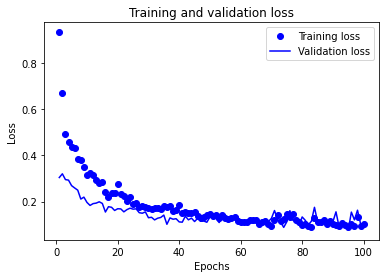

In [251]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs,loss, 'bo', label='Training loss') #blue dots
plt.plot(epochs,val_loss, 'b', label='Validation loss') #blue line
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

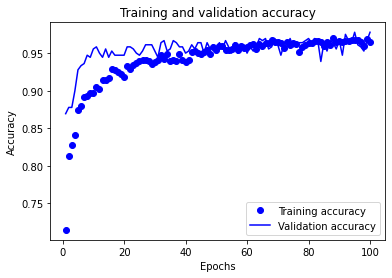

In [252]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs,acc, 'bo', label='Training accuracy') #blue dots
plt.plot(epochs,val_acc, 'b', label='Validation accuracy') #blue line
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Performance evaluation

In [254]:
# evaluating the model using the testing set
print(f"Evaluating the model using {len(data['X_test'])} samples...")
loss, accuracy = final_model.evaluate(data["X_test"], data["y_test"], verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

Evaluating the model using 400 samples...
Loss: 0.1271
Accuracy: 95.50%
